In [6]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_fn, get_data
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
exp_name = 'mae_0.1'
device = torch.device('cuda:0')

In [11]:
args = {'exp_name': exp_name,
        'config_file': 'GeospatialFM/configs/mae.yaml',
        'opts': None, 
        'save_config': False}
args = argparse.Namespace(**args)
args.debug = True
args

Namespace(exp_name='mae_0.1', config_file='GeospatialFM/configs/mae.yaml', opts=None, save_config=False, debug=True)

In [12]:
cfg, _ = setup(args)

In [22]:
data = get_data(cfg)

In [25]:
sample = iter(data['test'].dataloader).__next__()

In [19]:
save_path = os.path.join(cfg.TRAINER['output_dir'], 'model.pth')

In [32]:
model = construct_mae(cfg.MODEL)
model.load_state_dict(torch.load(save_path))
model = model.to(device)

In [78]:
model.eval()
with torch.no_grad():
    out = model(sample['image'].to(device), sample['radar'].to(device))

In [109]:
with torch.no_grad():
    out = model.forward_recon(sample['image'].to(device), sample['radar'].to(device))

In [110]:
out.keys()

dict_keys(['optical_cls_token', 'radar_cls_token', 'optical_recon', 'radar_recon', 'optical_mask', 'radar_mask'])

In [116]:
optical_recon = out['optical_recon'].cpu().numpy()
radar_recon = out['radar_recon'].cpu().numpy()
optical_input = sample['image'].cpu().numpy()
radar_input = sample['radar'].cpu().numpy()
optical_mask = out['optical_mask'].cpu().numpy()
radar_mask = out['radar_mask'].cpu().numpy()

In [118]:
optical_mask.shape

(256, 196)

In [120]:
sample_idx = 1
sample_channel = [3, 2, 1]
sample_r = 13
optical_recon_all = optical_recon[sample_idx].transpose(1, 2, 0)
radar_recon_all = radar_recon[sample_idx].transpose(1, 2, 0)
optical_input = optical_input[sample_idx].transpose(1, 2, 0)
radar_input = radar_input[sample_idx].transpose(1, 2, 0)

vis_optical_recon_o = optical_recon_all[:, :, sample_channel] 
vis_optical_recon_r = radar_recon_all[:, :, sample_r]
vis_optical_input = optical_input[:, :, sample_channel]
vis_radar_input = radar_input[:, :, 0]
vis_radar_recon_o = optical_recon_all[:, :, sample_channel]
vis_radar_recon_r = radar_recon_all[:, :, sample_r]
# normalize all images
vis_optical_recon_o = (vis_optical_recon_o - vis_optical_recon_o.min()) / (vis_optical_recon_o.max() - vis_optical_recon_o.min())
vis_optical_input = (vis_optical_input - vis_optical_input.min()) / (vis_optical_input.max() - vis_optical_input.min())
vis_radar_recon_o = (vis_radar_recon_o - vis_radar_recon_o.min()) / (vis_radar_recon_o.max() - vis_radar_recon_o.min())


Text(0.5, 1.0, 'Radar Recon')

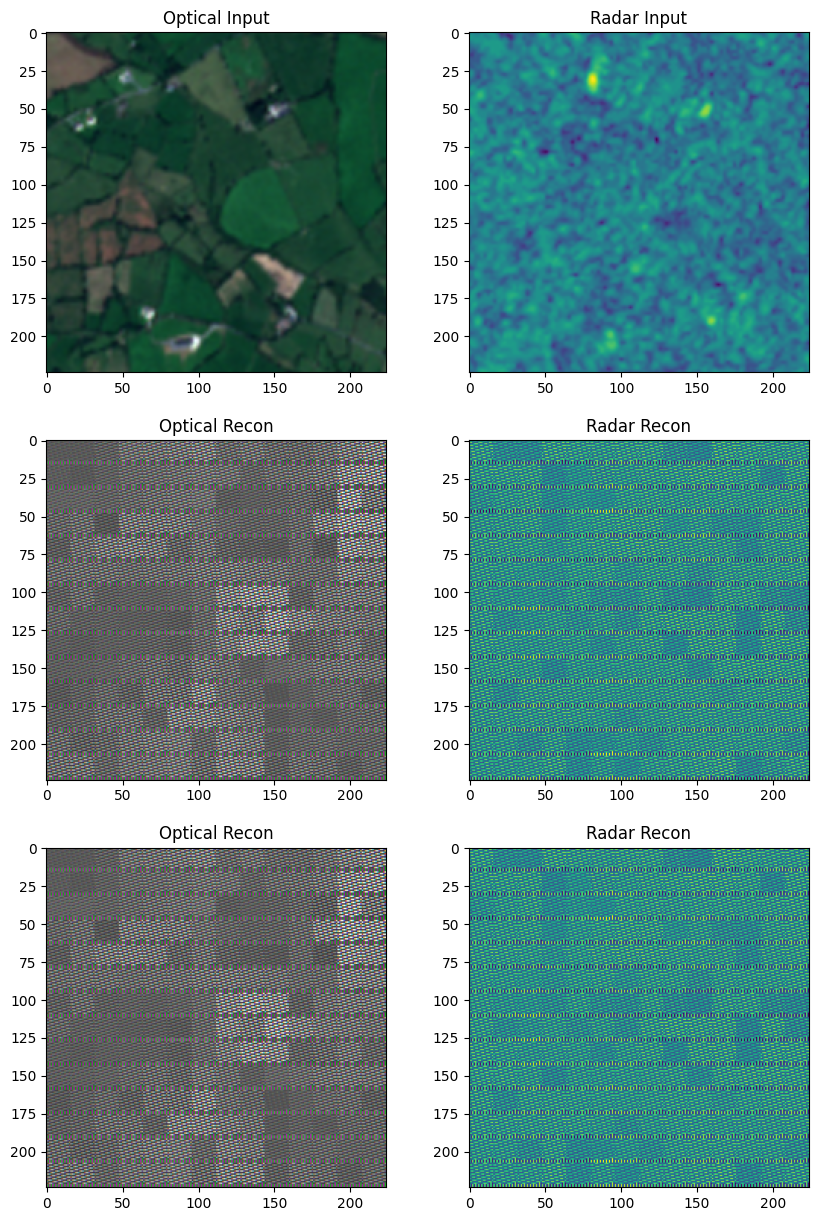

In [121]:
# plot a graph with 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
ax[0, 0].imshow(vis_optical_input)
ax[0, 0].set_title('Optical Input')
ax[0, 1].imshow(vis_radar_input)
ax[0, 1].set_title('Radar Input')

ax[1, 0].imshow(vis_optical_recon_o)
ax[1, 0].set_title('Optical Recon')
ax[1, 1].imshow(vis_optical_recon_r)
ax[1, 1].set_title('Radar Recon')

ax[2, 0].imshow(vis_radar_recon_o)
ax[2, 0].set_title('Optical Recon')
ax[2, 1].imshow(vis_radar_recon_r)
ax[2, 1].set_title('Radar Recon')

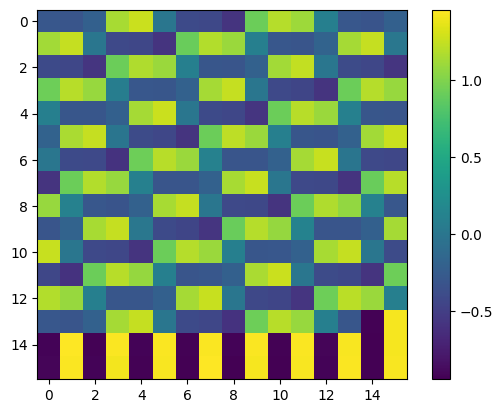

In [77]:
plt.imshow(optical_recon_all[:16, :16, [0]])
plt.colorbar()

In [93]:
recon = model.optical_decoder.unpatchify(out['optical_target'])
recon_img = recon[sample_idx].cpu().numpy().transpose(1, 2, 0)[:, :, [3, 2, 1]]
# normalize
recon_img = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min())

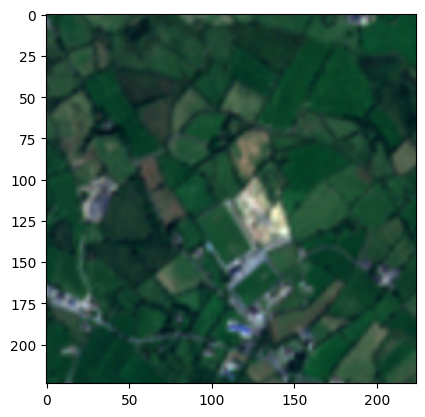

In [94]:
plt.imshow(recon_img)